In [246]:
from sklearn.feature_extraction.text import CountVectorizer
import json
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV,calibration_curve
import cytoolz
import tqdm
import scipy.sparse as sp
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt
import random
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

## Data Preprocess: 

In [75]:
def data_process(file_path,label_answer = 0):
    data = []
    labels = []
    with open(file_path, "r") as data_file:
        for line in data_file:
            line = line.strip("\n")
            if not line:
                continue
            review = json.loads(line)
            
            data.append(review['text'])
            if label_answer:
                labels.append(1 if review['meta']['label_answer'] == "POSITIVE" else 0)
            else:
                labels.append(1 if (review['label'] == "POSITIVE" and review['answer'] == "accept") or (review['label']=='NEGATIVE' and review['answer'] == 'reject') else 0)
    return data,labels
def shuffle_data(data,labels):
    trainset = list(zip(data,labels))
    random.shuffle(trainset)
    return zip(*trainset)

In [266]:
# data process
baseline_path = "/data/prodigy/data/IMDB_default/baseline_dataset_2000.jsonl"
eval_path = "/data/prodigy/data/IMDB_default/unique_eval.jsonl"
svm_path = "/data/prodigy/data/IMDB_default/custom_svm_ema_normalization_32.jsonl"
svm_pro_path = "/data/prodigy/data/IMDB_default/custom_svm_pro_normalization_32.jsonl"
log_path = "/data/prodigy/data/IMDB_default/custom_log_ema_32.jsonl"
log_pro_path = "/data/prodigy/data/IMDB_default/custom_log_pro_32.jsonl"
rest_eval_path ="/data/prodigy/data/IMDB_default/rest_eval.jsonl"
baseline_data,baseline_labels = data_process(baseline_path)
eval_data,eval_labels = data_process(eval_path)
rest_eval_data,rest_eval_labels = data_process(rest_eval_path)
svm_data,svm_labels = data_process(svm_path)
svm_pro_data,svm_pro_labels = data_process(svm_pro_path)
log_data,log_labels = data_process(log_path)
log_pro_data,log_pro_labels = data_process(log_pro_path)

baseline_uni_path = "/data/prodigy/data/IMDB_default/unique_baseline.jsonl"
log_uni_path = "/data/prodigy/data/IMDB_default/custom_log_ema_32_uni.jsonl"
baseline_uni_data,baseline_uni_labels = data_process(baseline_uni_path,1)
log_uni_sig_path = "/data/prodigy/data/IMDB_default/custom_log_ema_32_uni_sig.jsonl"
log_uni_data,log_uni_labels = data_process(log_uni_path)
log_uni_sig_data,log_uni_sig_labels = data_process(log_uni_sig_path)
svm_uni_path = "/data/prodigy/data/IMDB_default/custom_svm_ema_32_uni.jsonl"
svm_uni_data,svm_uni_labels = data_process(svm_uni_path)
svm_uni_normal_path = "/data/prodigy/data/IMDB_default/custom_svm_ema_32_uni_normal.jsonl"
svm_uni_normal_data,svm_uni_normal_labels = data_process(svm_uni_normal_path)
nb_uni_path = "/data/prodigy/data/IMDB_default/custom_nb_ema_32_uni.jsonl"
nb_uni_data,nb_uni_labels = data_process(nb_uni_path)

In [133]:
# build Vectorizer
vectorizer = CountVectorizer(min_df=5,
                             max_df = 0.8)

baseline_vectors = vectorizer.fit_transform(baseline_data)

eval_vectors = vectorizer.transform(eval_data)
svm_vectors = vectorizer.transform(svm_data)
svm_pro_vectors = vectorizer.transform(svm_pro_data)
log_vectors = vectorizer.transform(log_data)
log_pro_vectors = vectorizer.transform(log_pro_data)
baseline_uni_vectors = vectorizer.transform(baseline_uni_data)
log_uni_vectors = vectorizer.transform(log_uni_data)
svm_uni_vectors = vectorizer.transform(svm_uni_data)
log_uni_sig_vectors = vectorizer.transform(log_uni_sig_data)
svm_uni_normal_vectors = vectorizer.transform(svm_uni_normal_data)

In [267]:
nb_uni_vectors = vectorizer.transform(nb_uni_data)


In [268]:
nb_uni_vectors.shape

(2500, 10715)

In [226]:
rest_eval_vectors = vectorizer.transform(rest_eval_data)

In [86]:
# shuffle
baseline_uni_data_ran,baseline_uni_labels_ran = shuffle_data(baseline_uni_data,baseline_uni_labels)
baseline_uni_vectors_ran = vectorizer.transform(baseline_uni_data_ran)

## Probability Calibration

### 1. Logistic Regression

In [228]:
def plot_calibration_curve(est, name, fig_index,X_train,y_train,X_test,y_test):
    """Plot calibration curve for est w/o and with calibration. """
    # Calibrated with isotonic calibration
    isotonic = CalibratedClassifierCV(est, cv=2, method='isotonic')

    # Calibrated with sigmoid calibration
    sigmoid = CalibratedClassifierCV(est, cv=2, method='sigmoid')

    # Logistic regression with no calibration as baseline
    lr = LogisticRegression(C=1., solver='lbfgs')
    #lr = linear_model.SGDClassifier(loss="log",n_jobs=-1)
    fig = plt.figure(fig_index, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for clf, name in [(lr, 'Logistic'),
                      (est, name),
                      (isotonic, name + ' + Isotonic'),
                      (sigmoid, name + ' + Sigmoid')]:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        if hasattr(clf, "predict_proba"):
            prob_pos = clf.predict_proba(X_test)[:, 1]
        else:  # use decision function
            prob_pos = clf.decision_function(X_test)
            prob_pos = \
                (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())

        clf_score = brier_score_loss(y_test, prob_pos, pos_label=1)
        print("%s:" % name)
        print("\tBrier: %1.3f" % (clf_score))
        print("\tPrecision: %1.3f" % precision_score(y_test, y_pred))
        print("\tRecall: %1.3f" % recall_score(y_test, y_pred))
        print("\tF1: %1.3f\n" % f1_score(y_test, y_pred))

        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, prob_pos, n_bins=10)

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % (name, clf_score))

        ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
                 histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()


Logistic:
	Brier: 0.122
	Precision: 0.841
	Recall: 0.831
	F1: 0.836

Logistic SGD:
	Brier: 0.180
	Precision: 0.798
	Recall: 0.846
	F1: 0.821

Logistic SGD + Isotonic:
	Brier: 0.128
	Precision: 0.800
	Recall: 0.834
	F1: 0.817

Logistic SGD + Sigmoid:
	Brier: 0.126
	Precision: 0.823
	Recall: 0.837
	F1: 0.830



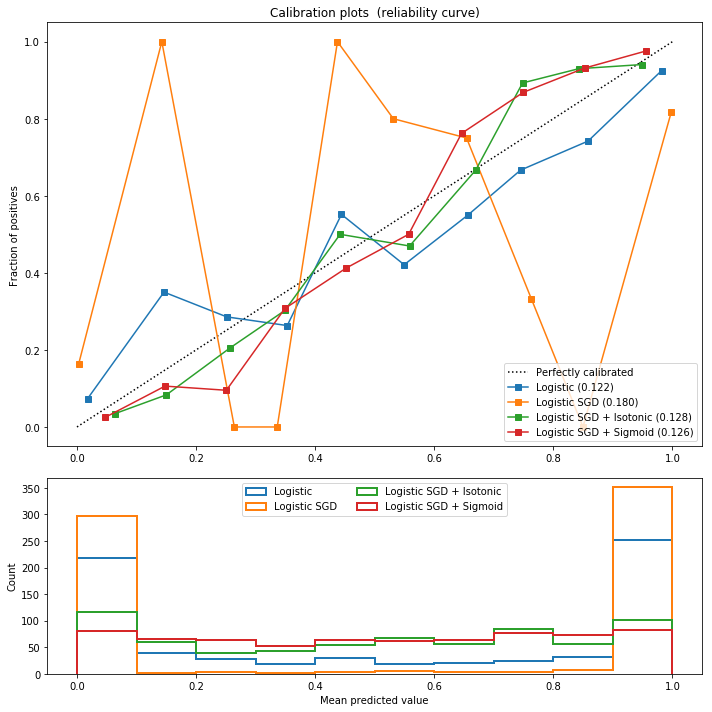

In [229]:
est = linear_model.SGDClassifier(loss="log",n_jobs=-1,max_iter=20)
plot_calibration_curve(est, "Logistic SGD", 1,baseline_uni_vectors,baseline_uni_labels,rest_eval_vectors,rest_eval_labels)

Logistic:
	Brier: 0.119
	Precision: 0.811
	Recall: 0.838
	F1: 0.824

SVM SGD:
	Brier: 0.187
	Precision: 0.771
	Recall: 0.851
	F1: 0.809

SVM SGD + Isotonic:
	Brier: 0.128
	Precision: 0.812
	Recall: 0.844
	F1: 0.828

SVM SGD + Sigmoid:
	Brier: 0.127
	Precision: 0.824
	Recall: 0.818
	F1: 0.821



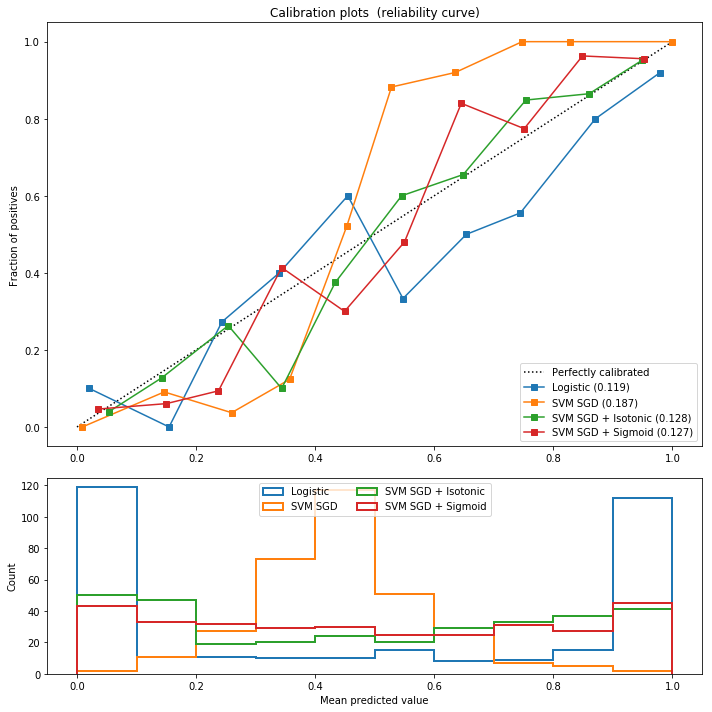

In [244]:
est = linear_model.SGDClassifier(loss="hinge",n_jobs=-1,max_iter=20)
plot_calibration_curve(est, "SVM SGD", 1,baseline_uni_vectors,baseline_uni_labels,eval_vectors,eval_labels)

In [192]:
clf = linear_model.SGDClassifier(loss="log",n_jobs=-1)
example1 = "The movie is good"
example2 = "The movie is bad"
# clf.partial_fit(vectorizer.transform([example1,example2]),[1,0],[0,1])
clf.fit(baseline_uni_vectors,baseline_uni_labels)
c = clf.predict_proba(eval_vectors)

/usr/lib64/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [152]:
clf = linear_model.SGDClassifier(loss="hinge",n_jobs=-1)
example1 = "The movie is good"
example2 = "The movie is bad"
# clf.partial_fit(vectorizer.transform([example1,example2]),[1,0],[0,1])
clf.fit(baseline_uni_vectors_ran,baseline_uni_labels_ran)
a = clf.decision_function(baseline_uni_vectors_ran)

/usr/lib64/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


(array([1.103e+03, 3.500e+01, 3.100e+01, 1.400e+01, 8.000e+00, 7.000e+00,
        9.000e+00, 9.000e+00, 5.000e+00, 6.000e+00, 1.000e+00, 0.000e+00,
        4.000e+00, 3.000e+00, 2.000e+00, 1.000e+00, 3.000e+00, 3.000e+00,
        3.000e+00, 5.000e+00, 0.000e+00, 1.000e+00, 3.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 3.000e+00, 0.000e+00, 3.000e+00, 2.000e+00,
        0.000e+00, 3.000e+00, 2.000e+00, 0.000e+00, 5.000e+00, 0.000e+00,
        4.000e+00, 0.000e+00, 0.000e+00, 3.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 2.000e+00, 2.000e+00, 0.000e+00, 5.000e+00, 0.000e+00,
        4.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 2.000e+00, 0.000e+00, 3.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 3.000e+00, 0.000e+00, 3.000e+00,
        1.000e+00, 0.000e+00, 3.000e+00, 4.000e+00, 1.000e+00, 0.000e+00,
        3.000e+00, 2.000e+00, 3.000e+0

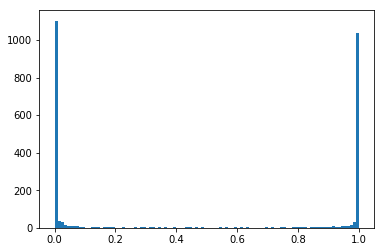

In [157]:
b = 1/(1+np.exp(-0.1*a))
#plt.hist(sorted(a))
plt.hist(sorted(b),bins=100)

(array([  1.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   1.,   1.,   0.,   1.,   1.,   3.,   2.,   2.,
          0.,   3.,   3.,   2.,   3.,   4.,   2.,   3.,   5.,   4.,   6.,
          6.,   9.,   9.,  13.,  18.,  23.,  21.,  33.,  36.,  42.,  53.,
         64.,  67., 102., 101., 107., 112., 104., 106., 116.,  70.,  55.,
         78.,  92., 102., 118., 118., 110.,  94.,  84.,  52.,  58.,  49.,
         31.,  33.,  24.,  29.,  14.,  16.,  10.,   7.,  13.,   5.,   3.,
         11.,   6.,   3.,   5.,   0.,   1.,   3.,   2.,   0.,   1.,   1.,
          2.,   2.,   1.,   0.,   0.,   0.,   3.,   0.,   1.,   1.,   0.,
          1.]),
 array([-1080.61142349, -1060.78773285, -1040.9640422 , -1021.14035156,
        -1001.31666091,  -981.49297027,  -961.66927963,  -941.84558898,
         -922.02189834,  -902.1982077 ,  -882.37451705,  -862.55082641,
         -842.72713576,  -822.90344512,  -803.07975448,  -783.25606383,
         -763.43237319,  -743.

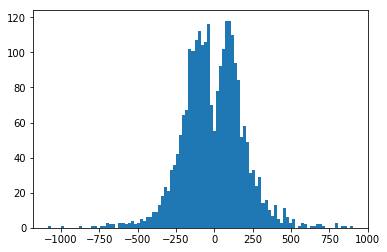

In [154]:
plt.hist(sorted(a),bins=100)

In [250]:
# cumulative
batch_size = 32
n_iter = 10
def batch_train_SVC(train_vectors,train_labels,n_iter):
    #clf = linear_model.SGDClassifier(loss="log")
    clf = SVC()
    result =[]
    for i in range(n_iter):
        clf = clf.fit(train_vectors,train_labels)
        #clf = clf.partial_fit(train_vectors,train_labels,[0,1])
        acc = clf.score(eval_vectors,eval_labels)
        result.append([len(train_labels),i+1,acc])
    return result
def batch_train_NB(train_vectors,train_labels,n_iter):
    clf = GaussianNB()
    #clf = SVC()
    result =[]
    for i in range(n_iter):
        #clf = clf.fit(train_vectors,train_labels)
        clf = clf.partial_fit(train_vectors.toarray(),train_labels,[0,1])
        acc = clf.score(eval_vectors.toarray(),eval_labels)
        result.append([len(train_labels),i+1,acc])
    return result
def batch_train_log(train_vectors,train_labels,n_iter):
    clf = linear_model.SGDClassifier(loss="log",n_jobs=-1,learning_rate = "optimal")
    #clf = SVC()
    result =[]
    for i in range(n_iter):
        #clf = clf.fit(train_vectors,train_labels)
        clf = clf.partial_fit(train_vectors,train_labels,[0,1])
        acc = clf.score(eval_vectors,eval_labels)
        result.append([len(train_labels),i+1,acc])
    return result

def batch_train_svm(train_vectors,train_labels,n_iter):
    clf = linear_model.SGDClassifier(loss="hinge",n_jobs=-1)
    #clf = SVC()
    result =[]
    for i in range(n_iter):
        #clf = clf.fit(train_vectors,train_labels)
        clf = clf.partial_fit(train_vectors,train_labels,[0,1])
        acc = clf.score(eval_vectors,eval_labels)
        result.append([len(train_labels),i+1,acc])
    return result

def cumulate_train(batch_train,train_vectors,train_labels,interval,n_iter):
    result = []
    for fac in np.arange(interval,train_vectors.shape[0]+interval,interval):
        train_sample = train_vectors[:fac]
        label_sample = train_labels[:fac]
        result.append(batch_train(train_sample,label_sample,n_iter))
    return result

In [269]:
# cumulate_baseline_SVC = cumulate_train(batch_train_SVC,baseline_vectors,baseline_labels,100,1)
# cumulate_baseline_svm = cumulate_train(batch_train_svm,baseline_vectors,baseline_labels,100,1)
# cumulate_baseline_log = cumulate_train(batch_train_log,baseline_vectors,baseline_labels,100,20)
#cumulate_baseline_log_1 = cumulate_train(batch_train_log,baseline_vectors_1,baseline_labels_1,100,20)
#cumulate_baseline_uni_log = cumulate_train(batch_train_log,baseline_uni_vectors,baseline_uni_labels,100,20)
#cumulate_baseline_uni_log_ran = cumulate_train(batch_train_log,baseline_uni_vectors_ran,baseline_uni_labels_ran,100,20)
# cumulate_baseline_uni_svm_20 = cumulate_train(batch_train_svm,baseline_uni_vectors,baseline_uni_labels,100,20)
# cumulate_baseline_uni_nb_20 = cumulate_train(batch_train_NB,baseline_uni_vectors,baseline_uni_labels,100,20)
#cumulate_baseline_uni_log_50 = cumulate_train(batch_train_log,baseline_uni_vectors,baseline_uni_labels,100,50)
#cumulate_uni_svm_20 = cumulate_train(batch_train_svm,svm_vectors,svm_labels,100,1)
#cumulate_uni_log_30 = cumulate_train(batch_train_log,log_uni_vectors,log_uni_labels,100,30)
# cumulate_uni_log_50 = cumulate_train(batch_train_log,log_uni_vectors,log_uni_labels,100,50)
# cumulate_uni_svm_20 = cumulate_train(batch_train_log,svm_uni_vectors,svm_uni_labels,100,20)
# cumulate_uni_normal_svm_20 = cumulate_train(batch_train_svm,svm_uni_normal_vectors,svm_uni_normal_labels,100,20)
cumulate_uni_nb_20 = cumulate_train(batch_train_NB,nb_uni_vectors,nb_uni_labels,100,20)

# cumulate_uni_log = cumulate_train(batch_train_log,log_uni_vectors,log_uni_labels,100,20)
#cumulate_SVC = cumulate_train(batch_train_SVC,svm_vectors,svm_labels,100,1)
#cumulate_pro_SVC = cumulate_train(batch_train_SVC,svm_pro_vectors,svm_pro_labels,100,1)
# cumulate_svm = cumulate_train(batch_train_svm,svm_vectors,svm_labels,100,1)
# cumulate_pro_svm = cumulate_train(batch_train_svm,svm_pro_vectors,svm_pro_labels,100,1)
#cumulate_log_1 = cumulate_train(batch_train_log,log_vectors,log_labels,100,1)
#cumulate_pro_log = cumulate_train(batch_train_log,log_pro_vectors,log_pro_labels,100,10)

# cumulate_uni_log_sig = cumulate_train(batch_train_log,log_uni_sig_vectors,log_uni_sig_labels,100,20)

In [270]:
n_iter = 20
# baseline_result_SVC = np.array(cumulate_baseline_SVC).reshape((50,n_iter,3))
# baseline_result_svm = np.array(cumulate_baseline_svm).reshape((50,n_iter,3))
baseline_result_log = np.array(cumulate_baseline_log).reshape((50,20,3))
baseline_result_log_1 = np.array(cumulate_baseline_log_1).reshape((50,20,3))

baseline_result_uni_log = np.array(cumulate_baseline_uni_log).reshape((len(cumulate_baseline_uni_log),20,3))
baseline_result_uni_log_ran = np.array(cumulate_baseline_uni_log_ran).reshape((len(cumulate_baseline_uni_log_ran),20,3))
baseline_result_uni_log_50 = np.array(cumulate_baseline_uni_log_50).reshape((len(cumulate_baseline_uni_log_50),50,3))

# SVC_result = np.array(cumulate_SVC).reshape(len(cumulate_SVC),n_iter,3)
# svm_result = np.array(cumulate_svm).reshape(len(cumulate_svm),n_iter,3)
baseline_result_uni_svm = np.array(cumulate_baseline_uni_svm_20).reshape((len(cumulate_baseline_uni_svm_20),20,3))
baseline_result_uni_nb = np.array(cumulate_baseline_uni_nb_20).reshape((len(cumulate_baseline_uni_nb_20),20,3))
svm_result_uni = np.array(cumulate_uni_svm_20).reshape(len(cumulate_uni_svm_20),20,3)
svm_result_uni_normal = np.array(cumulate_uni_normal_svm_20).reshape(len(cumulate_uni_normal_svm_20),20,3)
nb_result_uni = np.array(cumulate_uni_nb_20).reshape(len(cumulate_uni_nb_20),20,3)

log_result_uni = np.array(cumulate_uni_log).reshape(len(cumulate_uni_log),20,3)
log_result_uni_30 = np.array(cumulate_uni_log_30).reshape(len(cumulate_uni_log_30),30,3)
log_result_uni_50 = np.array(cumulate_uni_log_50).reshape(len(cumulate_uni_log_50),50,3)
# log_result_1 = np.array(cumulate_log_1).reshape(len(cumulate_log_1),1,3)
# log_result_10 = np.array(cumulate_log_10).reshape(len(cumulate_log_10),10,3)
# log_result_5 = np.array(cumulate_log_5).reshape(len(cumulate_log_5),5,3)
# log_result_20 = np.array(cumulate_log_20).reshape(len(cumulate_log_20),20,3)
log_result_uni_sig = np.array(cumulate_uni_log_sig).reshape(len(cumulate_uni_log_sig),20,3)


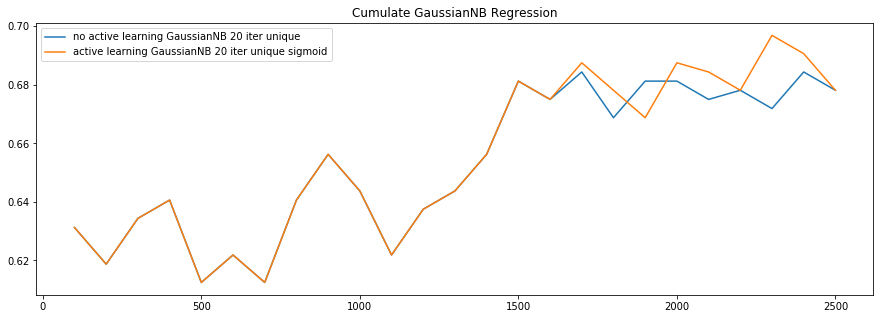

In [272]:
plt.figure(figsize=(15,5))
# plt.plot(baseline_result_SVC[:,-1,0],baseline_result_SVC[:,-1,-1],label="no active learning SVC")
# plt.plot(baseline_result_svm[:,-1,0],baseline_result_svm[:,-1,-1],label="no active learning svm SGD")
# plt.plot(SVC_result[:,-1,0],SVC_result[:,-1,-1],label=" active learning SVC")
# plt.plot(svm_result[:,-1,0],svm_result[:,-1,-1],label=" active learning svm SGD")
# plt.plot(baseline_result_uni_log[:,-1,0],np.max(baseline_result_uni_log[:,:,-1],1),label="no active learning log 20 iter unique")
#plt.plot(baseline_result_uni_log_ran[:,-1,0],np.max(baseline_result_uni_log_ran[:,:,-1],1),label="no active learning log 20 iter unique random")
#plt.plot(baseline_result_uni_log_50[:,-1,0],np.max(baseline_result_uni_log_50[:,:,-1],1),label="no active learning log 50 iter unique")
# plt.plot(baseline_result_uni_svm[:,-1,0],np.max(baseline_result_uni_svm[:,:,-1],1),label="no active learning svm 20 iter unique")
plt.plot(baseline_result_uni_nb[:,-1,0],np.max(baseline_result_uni_nb[:,:,-1],1),label="no active learning GaussianNB 20 iter unique")

# plt.plot(baseline_result_log[:,-1,0],np.max(baseline_result_log[:,:,-1],1),label="no active learning log 20 iter")
# plt.plot(baseline_result_log_1[:,-1,0],np.max(baseline_result_log_1[:,:,-1],1),label="no active learning log 20 iter random")
# #plt.plot(log_result_1[:,-1,0],np.max(log_result_1[:,:,-1],1),label="active learning log 1 iter")
#plt.plot(log_result_5[:,-1,0],np.max(log_result_5[:,:,-1],1),label="active learning log 5 iter")
#plt.plot(log_result_10[:,-1,0],np.max(log_result_10[:,:,-1],1),label="active learning log 10 iter")
# plt.plot(log_result_20[:,-1,0],np.max(log_result_20[:,:,-1],1),label="active learning log 20 iter")
# plt.plot(log_result_uni[:,-1,0],np.max(log_result_uni[:,:,-1],1),label="active learning log 20 iter unique")
# plt.plot(log_result_uni_30[:,-1,0],np.max(log_result_uni_30[:,:,-1],1),label="active learning log 30 iter unique")
# plt.plot(svm_result_uni[:,-1,0],np.max(svm_result_uni[:,:,-1],1),label="active learning svm 20 iter unique sigmoid")
# plt.plot(svm_result_uni_normal[:,-1,0],np.max(svm_result_uni_normal[:,:,-1],1),label="active learning svm 20 iter unique normalization")
plt.plot(nb_result_uni[:,-1,0],np.max(nb_result_uni[:,:,-1],1),label="active learning GaussianNB 20 iter unique sigmoid")

# plt.plot(log_result_uni_sig[:,-1,0],np.max(log_result_uni_sig[:,:,-1],1),label="active learning log sigmoid 20 iter unique")

#plt.title("Cumulate "+str(n_iter)+" iterations")
plt.title("Cumulate GaussianNB Regression")
plt.legend()

In [44]:
#compare accuracy for different iterations
cumulate_baseline_log = cumulate_train(batch_train_log,baseline_vectors,baseline_labels,100,20)
cumulate_log_1 = cumulate_train(batch_train_log,log_vectors,log_labels,100,1)
cumulate_log_10 = cumulate_train(batch_train_log,log_vectors,log_labels,100,10)
cumulate_log_5 = cumulate_train(batch_train_log,log_vectors,log_labels,100,5)
cumulate_log_20 = cumulate_train(batch_train_log,log_vectors,log_labels,100,20)
baseline_result_log = np.array(cumulate_baseline_log).reshape((50,20,3))
log_result_1 = np.array(cumulate_log_1).reshape(len(cumulate_log_1),1,3)
log_result_10 = np.array(cumulate_log_10).reshape(len(cumulate_log_10),10,3)
log_result_5 = np.array(cumulate_log_5).reshape(len(cumulate_log_5),5,3)
log_result_20 = np.array(cumulate_log_20).reshape(len(cumulate_log_20),20,3)
plt.plot(baseline_result_log[:,-1,0],np.max(baseline_result_log[:,:,-1],1),label="no active learning log 20 iter")
plt.plot(log_result_1[:,-1,0],np.max(log_result_1[:,:,-1],1),label="active learning log 1 iter")
plt.plot(log_result_5[:,-1,0],np.max(log_result_5[:,:,-1],1),label="active learning log 5 iter")
plt.plot(log_result_10[:,-1,0],np.max(log_result_10[:,:,-1],1),label="active learning log 10 iter")
plt.plot(log_result_20[:,-1,0],np.max(log_result_20[:,:,-1],1),label="active learning log 20 iter")
plt.title("Cumulate Log Regression")
plt.legend()

/usr/lib64/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [46]:
cumulate_baseline_log = cumulate_train(batch_train_log,baseline_vectors,baseline_labels,100,20)
cumulate_baseline_log_1 = cumulate_train(batch_train_log,baseline_vectors_1,baseline_labels_1,100,20)
baseline_result_log = np.array(cumulate_baseline_log).reshape((50,20,3))
baseline_result_log_1 = np.array(cumulate_baseline_log_1).reshape((50,20,3))
plt.plot(baseline_result_log[:,-1,0],np.max(baseline_result_log[:,:,-1],1),label="no active learning log 20 iter")
plt.plot(baseline_result_log_1[:,-1,0],np.max(baseline_result_log_1[:,:,-1],1),label="no active learning log 20 iter random")
plt.plot(log_result_20[:,-1,0],np.max(log_result_20[:,:,-1],1),label="active learning log 20 iter")
plt.title("Cumulate Log Regression")
plt.legend()

/usr/lib64/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [275]:
#baseline_result = np.array(cumulate_baseline).reshape((50,1,3))
#svm_result = np.array(cumulate_svm).reshape(len(cumulate_svm),1,3)
#log_result = np.array(cumulate_log1).reshape(len(cumulate_log1),1,3)
log_pro_result = np.array(cumulate_pro_log).reshape(len(cumulate_pro_log),1,3)
plt.plot(baseline_result[:,-1,0],baseline_result[:,-1,-1],label="no active learning")
#plt.plot(svm_result[:,-1,0],svm_result[:,-1,-1],label=" active learning")
# plt.plot(log_result[:,-1,0],log_result[:,-1,-1],label=" active learning")
plt.plot(log_pro_result[:,-1,0],log_pro_result[:,-1,-1],label=" active learning")
plt.title("Logistice Regression Cumulate 1 iterations")
plt.legend()

NameError: name 'baseline_result' is not defined

In [181]:
# incremental graph
def increment_train(train_vectors,train_labels,n_iter,batch_size):
    clf = linear_model.SGDClassifier(loss="log")
    result =[]
    for idx in np.arange(batch_size,train_vectors.shape[0]+batch_size,batch_size):
        for i in range(n_iter):
            clf = clf.partial_fit(train_vectors[idx-batch_size:idx],train_labels[idx-batch_size:idx],[0,1])
            acc = clf.score(eval_vectors,eval_labels)
            result.append([int(idx/batch_size),i+1,acc])
    return result

In [191]:
increment_baseline = increment_train(baseline_vectors,baseline_labels,1,32)
#increment_svm = increment_train(svm_vectors,svm_labels,1,32)
#increment_pro_svm = increment_train(svm_pro_vectors,svm_pro_labels,1,32)
increment_log = increment_train(log_vectors,log_labels,1,32)
#increment_pro_log = increment_train(log_pro_vectors,log_pro_labels,5,32)

/usr/lib64/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [192]:
len(increment[0])

3

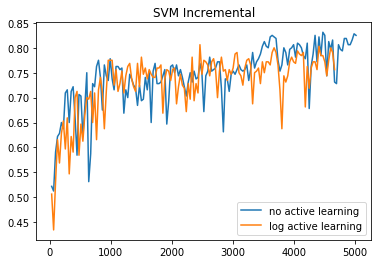

In [193]:
increment_baseline = np.array(increment_baseline)
#increment_svm = np.array(increment_svm)
#increment_pro_svm = np.array(increment_pro_svm)
increment_log = np.array(increment_log)
#increment_pro_log = np.array(increment_pro_log)
#result = result.reshape((50,10,3))
# plt.plot(32*increment_baseline[:,0],increment_baseline[:,-1],label="no active learning")
#plt.plot(32*increment_svm[:,0],increment_svm[:,-1],label="active learning")
plt.plot(32*increment_baseline[:,0],increment_baseline[:,-1],label="no active learning")
plt.plot(32*increment_log[:,0],increment_log[:,-1],label="log active learning")
# plt.plot(32*increment_pro_log[:,0],increment_pro_log[:,-1],label="log pro active learning")
#plt.plot(32*increment_pro_svm[:,0],increment_pro_svm[:,-1],label="probability active learning")
plt.title("SVM Incremental")
plt.legend()

In [55]:
batch_size = 32
n_iter = 10
clf = SVC()

for idx in np.arange(batch_size,len(train_data)+batch_size,batch_size):
    for i in range(n_iter):
        clf.fit(train_vectors[idx-batch_size:idx],train_labels[idx-batch_size:idx])
        acc = clf.score(test_vectors,test_labels)
        print(int(idx/batch_size),i+1,acc)
#     break

1.0 1 0.51875
1.0 2 0.51875
1.0 3 0.51875
1.0 4 0.51875
1.0 5 0.51875
1.0 6 0.51875
1.0 7 0.51875
1.0 8 0.51875
1.0 9 0.51875
1.0 10 0.51875
2.0 1 0.51875
2.0 2 0.51875
2.0 3 0.51875
2.0 4 0.51875
2.0 5 0.51875
2.0 6 0.51875
2.0 7 0.51875
2.0 8 0.51875
2.0 9 0.51875
2.0 10 0.51875
3.0 1 0.48125
3.0 2 0.48125
3.0 3 0.48125
3.0 4 0.48125
3.0 5 0.48125
3.0 6 0.48125
3.0 7 0.48125
3.0 8 0.48125
3.0 9 0.48125
3.0 10 0.48125
4.0 1 0.528125
4.0 2 0.528125
4.0 3 0.528125
4.0 4 0.528125
4.0 5 0.528125
4.0 6 0.528125
4.0 7 0.528125
4.0 8 0.528125
4.0 9 0.528125
4.0 10 0.528125
5.0 1 0.540625
5.0 2 0.540625
5.0 3 0.540625
5.0 4 0.540625
5.0 5 0.540625
5.0 6 0.540625
5.0 7 0.540625
5.0 8 0.540625
5.0 9 0.540625
5.0 10 0.540625
6.0 1 0.48125
6.0 2 0.48125
6.0 3 0.48125
6.0 4 0.48125
6.0 5 0.48125
6.0 6 0.48125
6.0 7 0.48125
6.0 8 0.48125
6.0 9 0.48125
6.0 10 0.48125
7.0 1 0.51875
7.0 2 0.51875
7.0 3 0.51875
7.0 4 0.51875
7.0 5 0.51875
7.0 6 0.51875
7.0 7 0.51875
7.0 8 0.51875
7.0 9 0.51875
7.0 10 0

57.0 2 0.51875
57.0 3 0.51875
57.0 4 0.51875
57.0 5 0.51875
57.0 6 0.51875
57.0 7 0.51875
57.0 8 0.51875
57.0 9 0.51875
57.0 10 0.51875
58.0 1 0.51875
58.0 2 0.51875
58.0 3 0.51875
58.0 4 0.51875
58.0 5 0.51875
58.0 6 0.51875
58.0 7 0.51875
58.0 8 0.51875
58.0 9 0.51875
58.0 10 0.51875
59.0 1 0.51875
59.0 2 0.51875
59.0 3 0.51875
59.0 4 0.51875
59.0 5 0.51875
59.0 6 0.51875
59.0 7 0.51875
59.0 8 0.51875
59.0 9 0.51875
59.0 10 0.51875
60.0 1 0.48125
60.0 2 0.48125
60.0 3 0.48125
60.0 4 0.48125
60.0 5 0.48125
60.0 6 0.48125
60.0 7 0.48125
60.0 8 0.48125
60.0 9 0.48125
60.0 10 0.48125
61.0 1 0.48125
61.0 2 0.48125
61.0 3 0.48125
61.0 4 0.48125
61.0 5 0.48125
61.0 6 0.48125
61.0 7 0.48125
61.0 8 0.48125
61.0 9 0.48125
61.0 10 0.48125
62.0 1 0.51875
62.0 2 0.51875
62.0 3 0.51875
62.0 4 0.51875
62.0 5 0.51875
62.0 6 0.51875
62.0 7 0.51875
62.0 8 0.51875
62.0 9 0.51875
62.0 10 0.51875
63.0 1 0.51875
63.0 2 0.51875
63.0 3 0.51875
63.0 4 0.51875
63.0 5 0.51875
63.0 6 0.51875
63.0 7 0.51875
63.0

111.0 6 0.51875
111.0 7 0.51875
111.0 8 0.51875
111.0 9 0.51875
111.0 10 0.51875
112.0 1 0.51875
112.0 2 0.51875
112.0 3 0.51875
112.0 4 0.51875
112.0 5 0.51875
112.0 6 0.51875
112.0 7 0.51875
112.0 8 0.51875
112.0 9 0.51875
112.0 10 0.51875
113.0 1 0.51875
113.0 2 0.51875
113.0 3 0.51875
113.0 4 0.51875
113.0 5 0.51875
113.0 6 0.51875
113.0 7 0.51875
113.0 8 0.51875
113.0 9 0.51875
113.0 10 0.51875
114.0 1 0.48125
114.0 2 0.48125
114.0 3 0.48125
114.0 4 0.48125
114.0 5 0.48125
114.0 6 0.48125
114.0 7 0.48125
114.0 8 0.48125
114.0 9 0.48125
114.0 10 0.48125
115.0 1 0.48125
115.0 2 0.48125
115.0 3 0.48125
115.0 4 0.48125
115.0 5 0.48125
115.0 6 0.48125
115.0 7 0.48125
115.0 8 0.48125
115.0 9 0.48125
115.0 10 0.48125
116.0 1 0.51875
116.0 2 0.51875
116.0 3 0.51875
116.0 4 0.51875
116.0 5 0.51875
116.0 6 0.51875
116.0 7 0.51875
116.0 8 0.51875
116.0 9 0.51875
116.0 10 0.51875
117.0 1 0.51875
117.0 2 0.51875
117.0 3 0.51875
117.0 4 0.51875
117.0 5 0.51875
117.0 6 0.51875
117.0 7 0.51875
11

In [53]:
np.arange(batch_size,len(train_data)+batch_size,batch_size)

array([  32,   64,   96,  128,  160,  192,  224,  256,  288,  320,  352,
        384,  416,  448,  480,  512,  544,  576,  608,  640,  672,  704,
        736,  768,  800,  832,  864,  896,  928,  960,  992, 1024, 1056,
       1088, 1120, 1152, 1184, 1216, 1248, 1280, 1312, 1344, 1376, 1408,
       1440, 1472, 1504, 1536, 1568, 1600, 1632, 1664, 1696, 1728, 1760,
       1792, 1824, 1856, 1888, 1920, 1952, 1984, 2016, 2048, 2080, 2112,
       2144, 2176, 2208, 2240, 2272, 2304, 2336, 2368, 2400, 2432, 2464,
       2496, 2528, 2560, 2592, 2624, 2656, 2688, 2720, 2752, 2784, 2816,
       2848, 2880, 2912, 2944, 2976, 3008, 3040, 3072, 3104, 3136, 3168,
       3200, 3232, 3264, 3296, 3328, 3360, 3392, 3424, 3456, 3488, 3520,
       3552, 3584, 3616, 3648, 3680, 3712, 3744, 3776, 3808, 3840, 3872,
       3904, 3936, 3968, 4000, 4032, 4064, 4096, 4128, 4160, 4192, 4224,
       4256, 4288, 4320, 4352, 4384, 4416, 4448, 4480, 4512, 4544, 4576,
       4608, 4640, 4672, 4704, 4736, 4768, 4800, 48

In [31]:
sp.csr_matrix(train_labels).transpose().shape

(5000, 1)

In [36]:
train_loader[:,:-1]

<5000x10715 sparse matrix of type '<class 'numpy.int64'>'
	with 589350 stored elements in Compressed Sparse Row format>